# Стратегия взаимодействия с клиентами фитнес-центров «Культурист-датасаентист»

Задача — провести анализ и подготовить план действий по удержанию клиентов:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      1) выделить целевые группы клиентов;
      2) предложить меры по снижению оттока;
      3) определить другие особенности взаимодействия с клиентами.
      
Исходные данные:
- данные клиентов за предыдущий до проверки факта оттока месяц;
- информация на основе журнала посещений;
- информация о покупках;
- информация о текущем статусе абонемента клиента.
        
## Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings

# отключение предупреждений
warnings.filterwarnings('ignore')

In [2]:
# настройки графиков
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# увеличение максимального длины отображаемых значений таблицы
pd.set_option("max_colwidth", 300)

In [3]:
# чтение файла
df = pd.read_csv('/datasets/gym_churn.csv')

## Исследовательский анализ данных (EDA)

In [4]:
def first_look(df):
    '''Функция для просмотра основной информации о таблице'''
    print('Первые 5 строк таблицы:')
    display(df.head())
    print('Информация о таблице:')
    df.info()
    display(df.describe())
    print('Количество строк и столбцов:')
    print(df.shape)
    print('Количество пропусков:')
    if df.isna().sum().sum()==0:
        print('пропусков нет')
    else:
        print(df.isna().sum())
    print('Количество дубликатов:')
    if df.duplicated().sum()==0:
        print('дубликатов нет')
    else:
        print(df.duplicated().sum())

In [5]:
first_look(df)

Первые 5 строк таблицы:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total         

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Количество строк и столбцов:
(4000, 14)
Количество пропусков:
пропусков нет
Количество дубликатов:
дубликатов нет


Вырисовуется картина среднестатистического клиента:
- живет или работает рядом с фитнес-центром;
- не является сотрудником компании-партнера;
- не пришел через акцию "Приведи друга";
- оставил контактный телефон;
- купил абонемент на один месяц;
- не посещает групповые занятия;
- возраст - 29 лет;
- тратит +/- 140 денежных единиц на дополнительные услуги фитнес-центра;
- впервые посетил фитнес-центр три месяца назад;
- в среднем посещает занятия 7 раз в месяц (чуть реже 2 раз в неделю)

In [6]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [7]:
# разделим клиентов на две группы: те, кто ушли и те, кто остались, и посмотрим на средние значения в этих группах
df.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На основе этих данных можно сделать следующие выводы:
- gender: доля мужчин и женщин в обеих группах одинаковы
- near_location: доля живущих рядом на 10% больше среди оставшихся клиентов
- partner: доля пришедших из компании-партнера на 50% больше среди оставшихся клиентов
- promo_friends: доля пришедщих по акции "Приведи друга" в 2 раза больше среди оставшихся клиентов
- phone: доли клиентов с контактным телефоном и без в обеих группах одинаковы
- contract_period: cредняя длительность абонемента в 3 раза выше среди оставшихся клиентов
- group_visits: доля ходящих на групповые занятия почти в 2 раза больше среди оставшихся клиентов
- age: средний возраст оставшихся клиентов на 3 года больше, чем ушедших
- avg_additional_charges_total: средняя выручка от других услуг центра на 30% выше среди оставшихся клиентов
- month_to_end_contract: число месяцев до окончания абонемента в 3 раза выше среди оставшихся клиентов
- lifetime: время с момента первого обращения почти в 5 раз выше среди оставшихся клиентов
- avg_class_frequency_total: средняя частота посещений в неделю за все время с начала действия абонемента на 30% выше среди оставшихся клиентов
- avg_class_frequency_current_month: средняя частота посещений в неделю за предыдущий месяц в 2 раза выше среди оставшихся клиентов

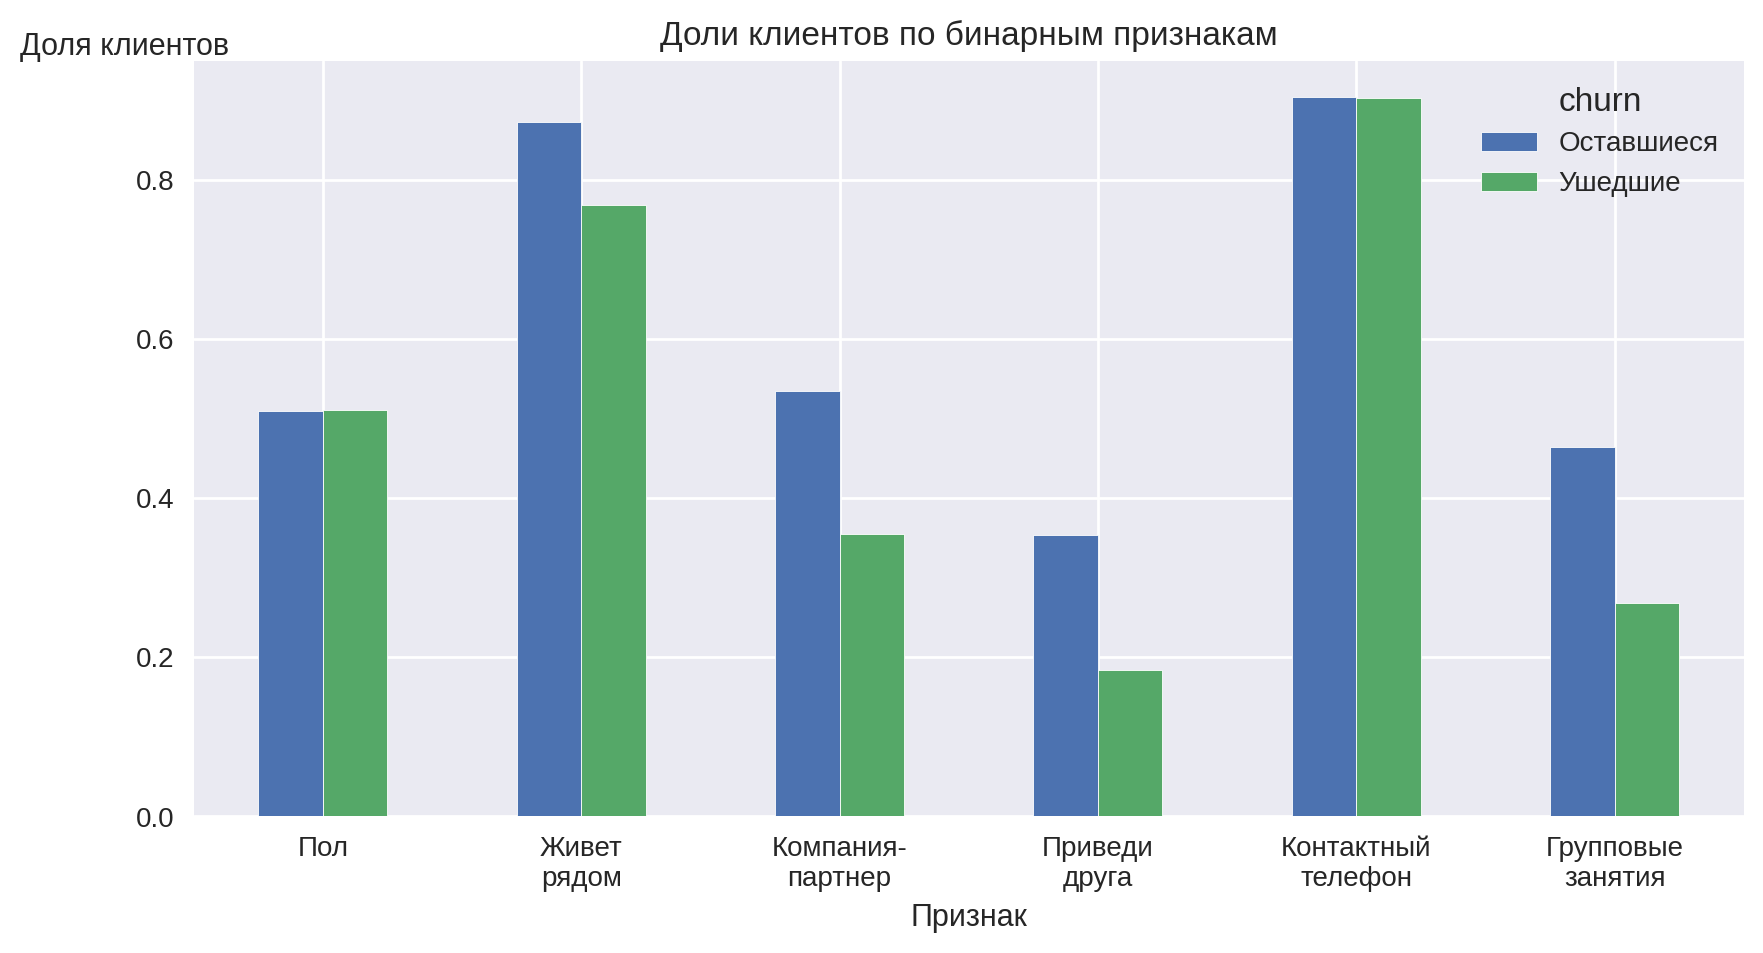

In [8]:
# создадим список с бинарными признаками
binary_features = ['gender','near_location','partner','promo_friends','phone','group_visits']

# построим столбчатую диаграмму
with plt.style.context('seaborn'):
    df.groupby('churn')[binary_features].agg('mean').\
    rename(columns={'gender': 'Пол','near_location':'Живет\nрядом','partner':'Компания-\nпартнер',\
                     'promo_friends':'Приведи\nдруга','phone':'Контактный\nтелефон','group_visits':'Групповые\nзанятия'},\
           index={0: 'Оставшиеся', 1: 'Ушедшие'}).\
    T.plot(kind='bar', figsize=(10, 5))
    plt.title('Доли клиентов по бинарным признакам')
    plt.xlabel('Признак')
    plt.ylabel('Доля клиентов', rotation=0, position = (0,1))
    plt.xticks(rotation=0)
    plt.show()

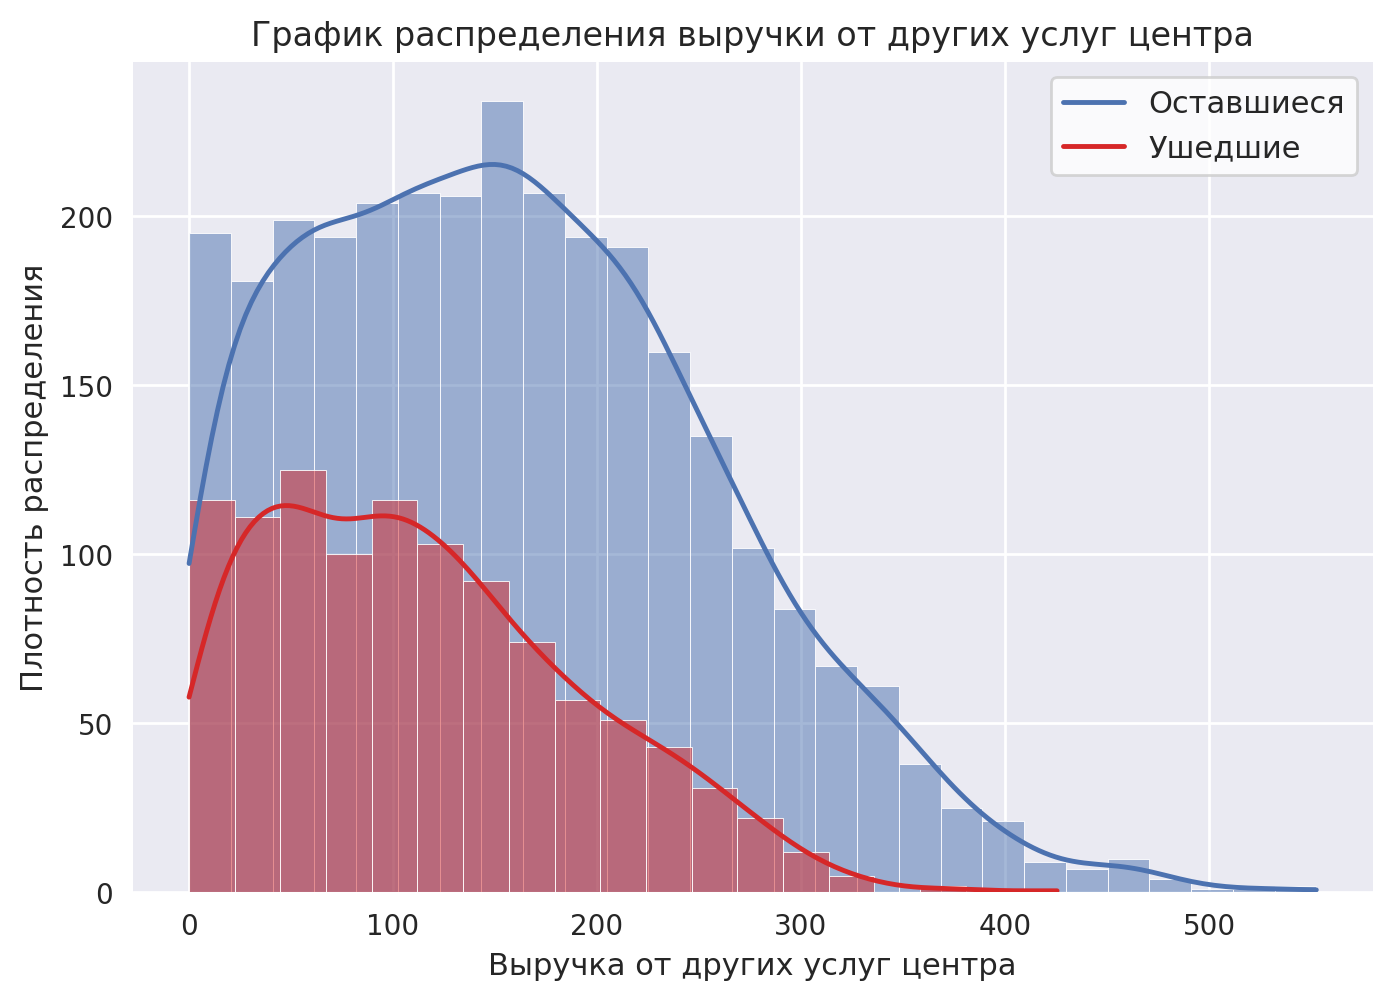

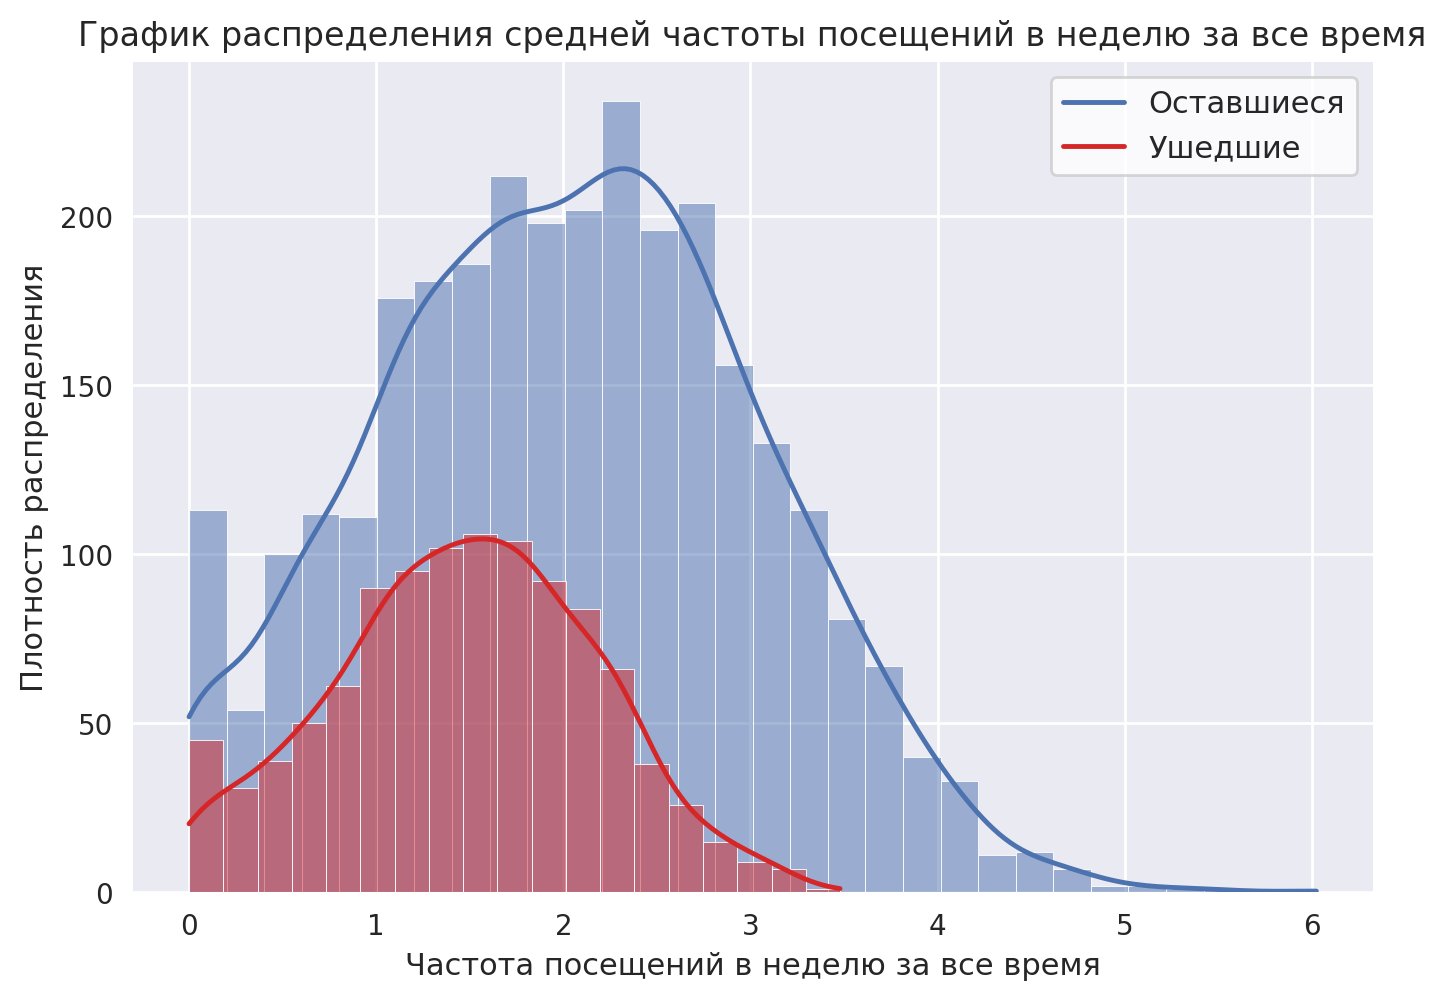

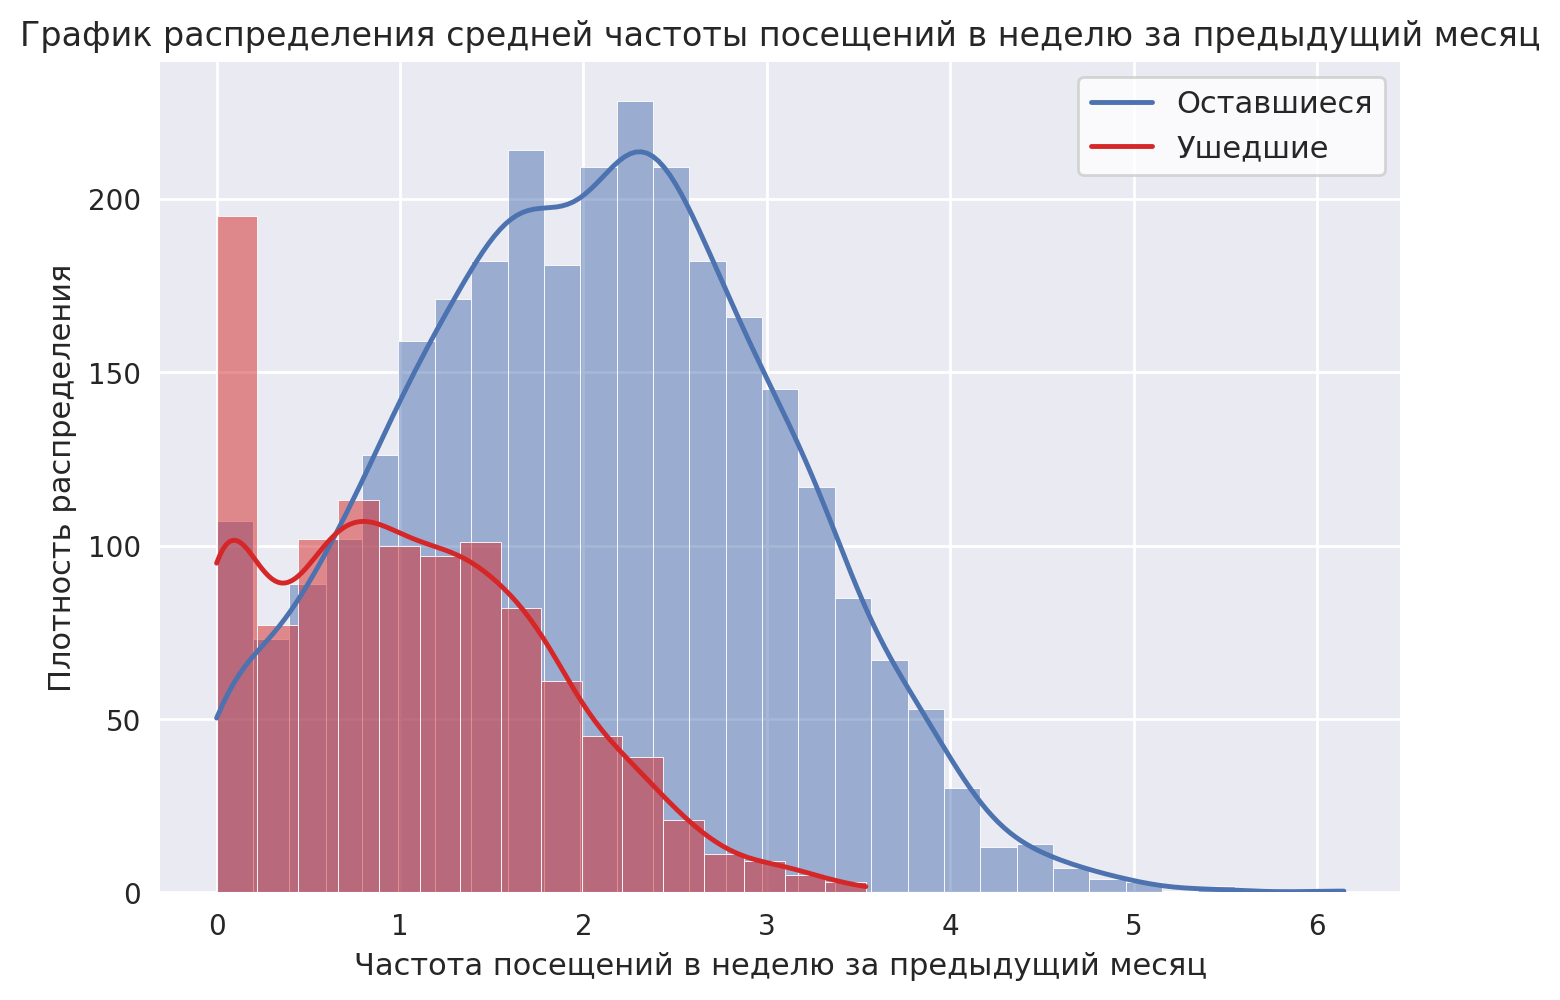

In [9]:
# создадим список с небинарными признаками с большим разбросом значений
num_features = ['avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month']
titles= ['График распределения выручки от других услуг центра', 
         'График распределения средней частоты посещений в неделю за все время', 
         'График распределения средней частоты посещений в неделю за предыдущий месяц']
labels= ['Выручка от других услуг центра', 'Частота посещений в неделю за все время', 'Частота посещений в неделю за предыдущий месяц']

# построим графики распределения
for col, title, label in zip(num_features, titles, labels):
    with plt.style.context('seaborn'):
        sns.histplot(df[df['churn'] == 0][col], kde=True)
        sns.histplot(df[df['churn'] == 1][col], kde=True, color='tab:red')
    labels= ["Оставшиеся", "Ушедшие"]
    plt.grid(True)
    plt.title(title)
    plt.legend(labels)
    plt.xlabel(label)
    plt.ylabel('Плотность распределения')
    plt.show()

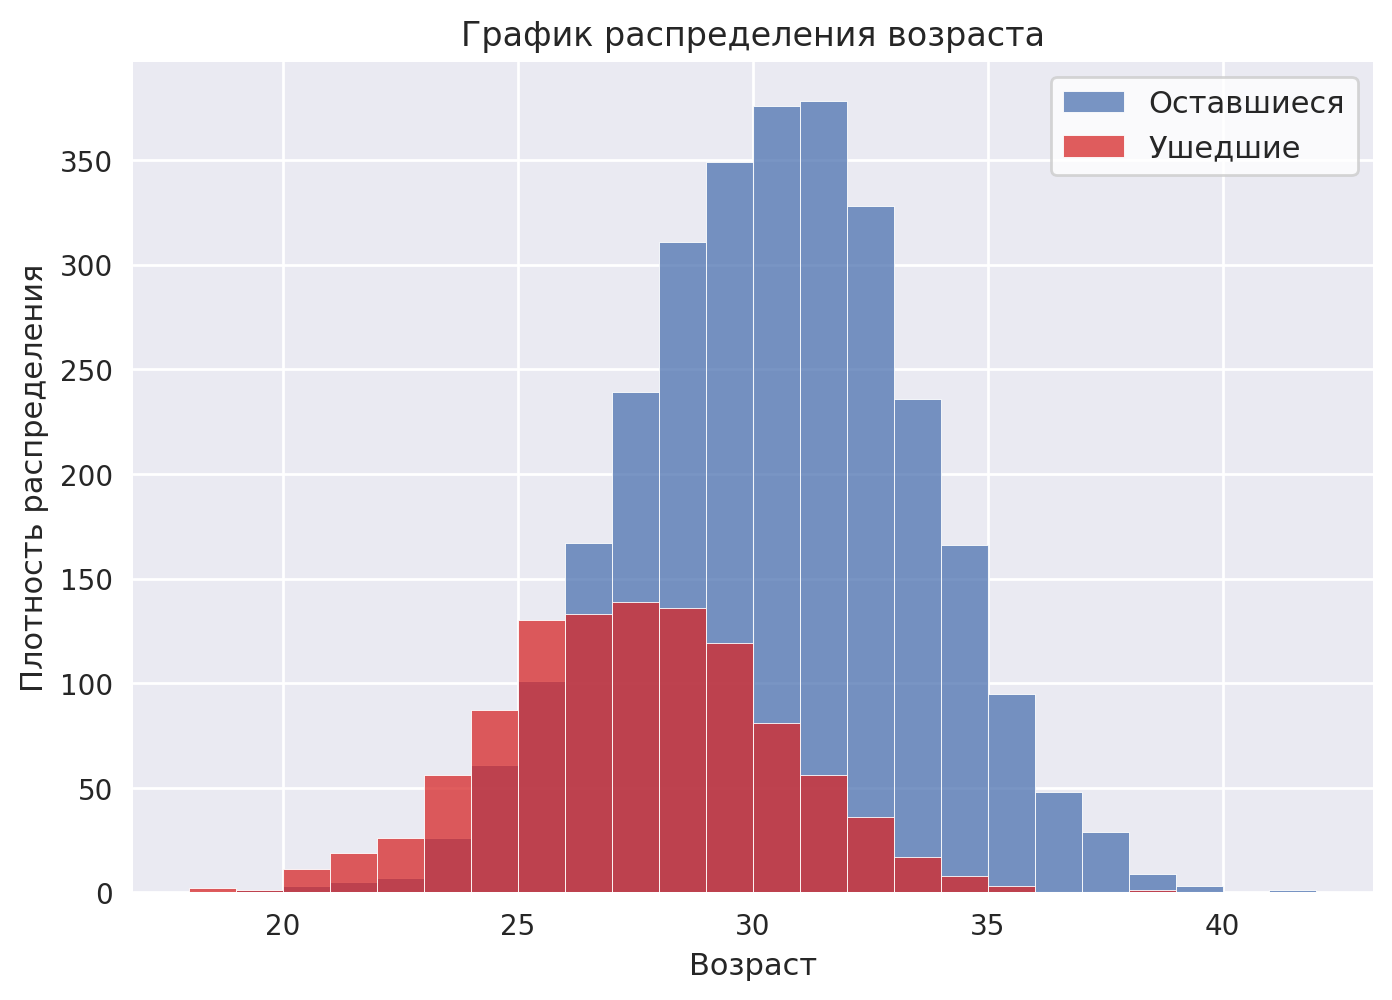

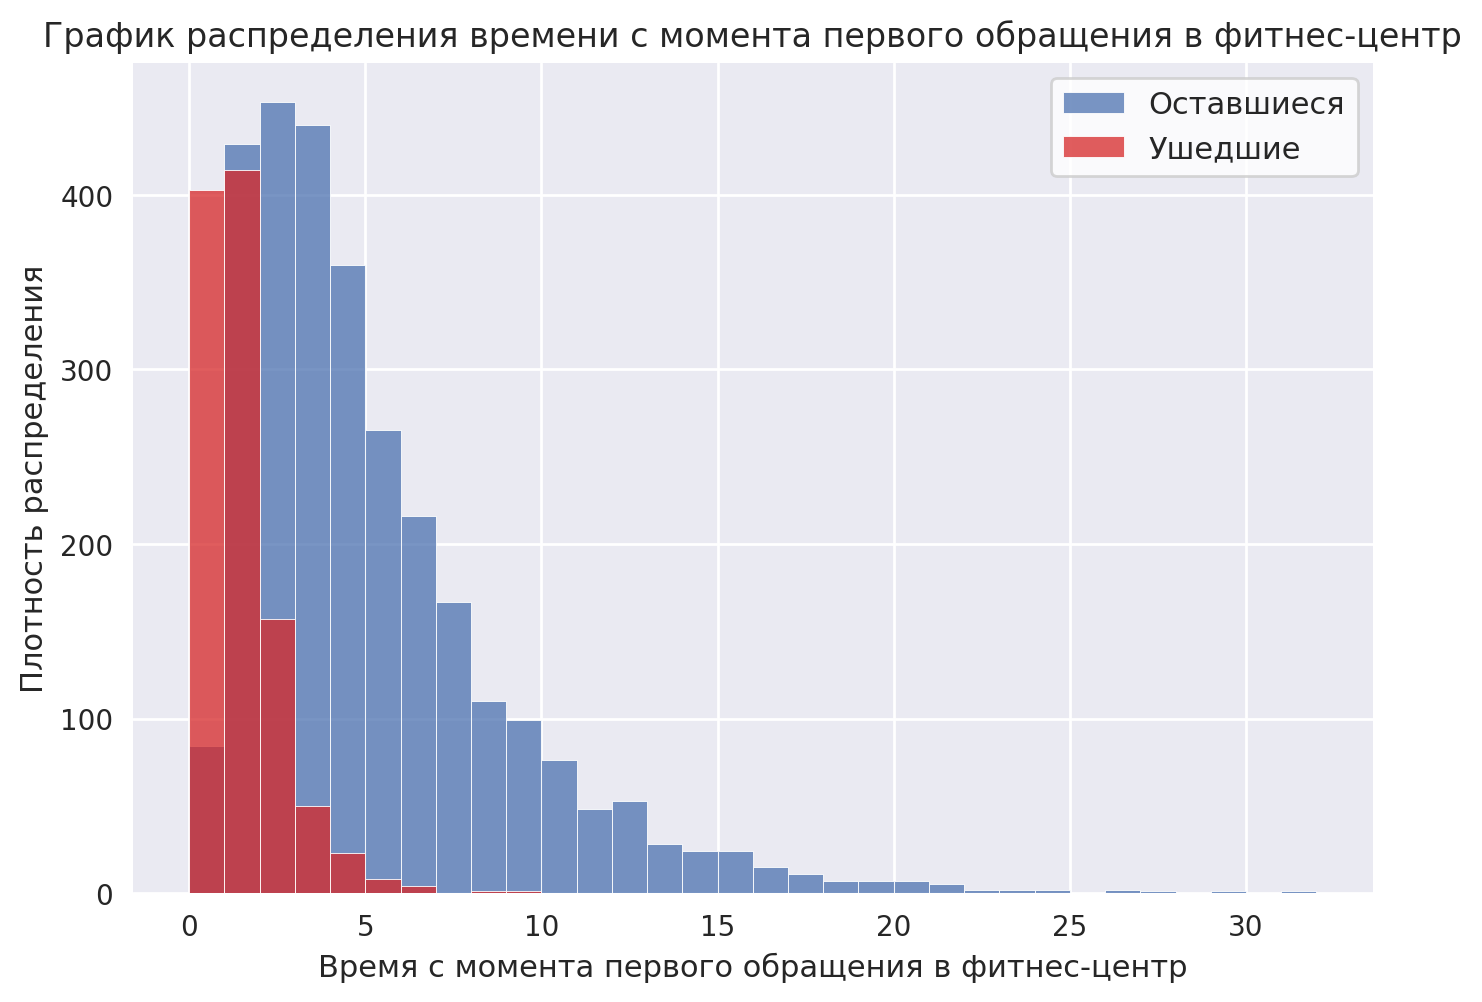

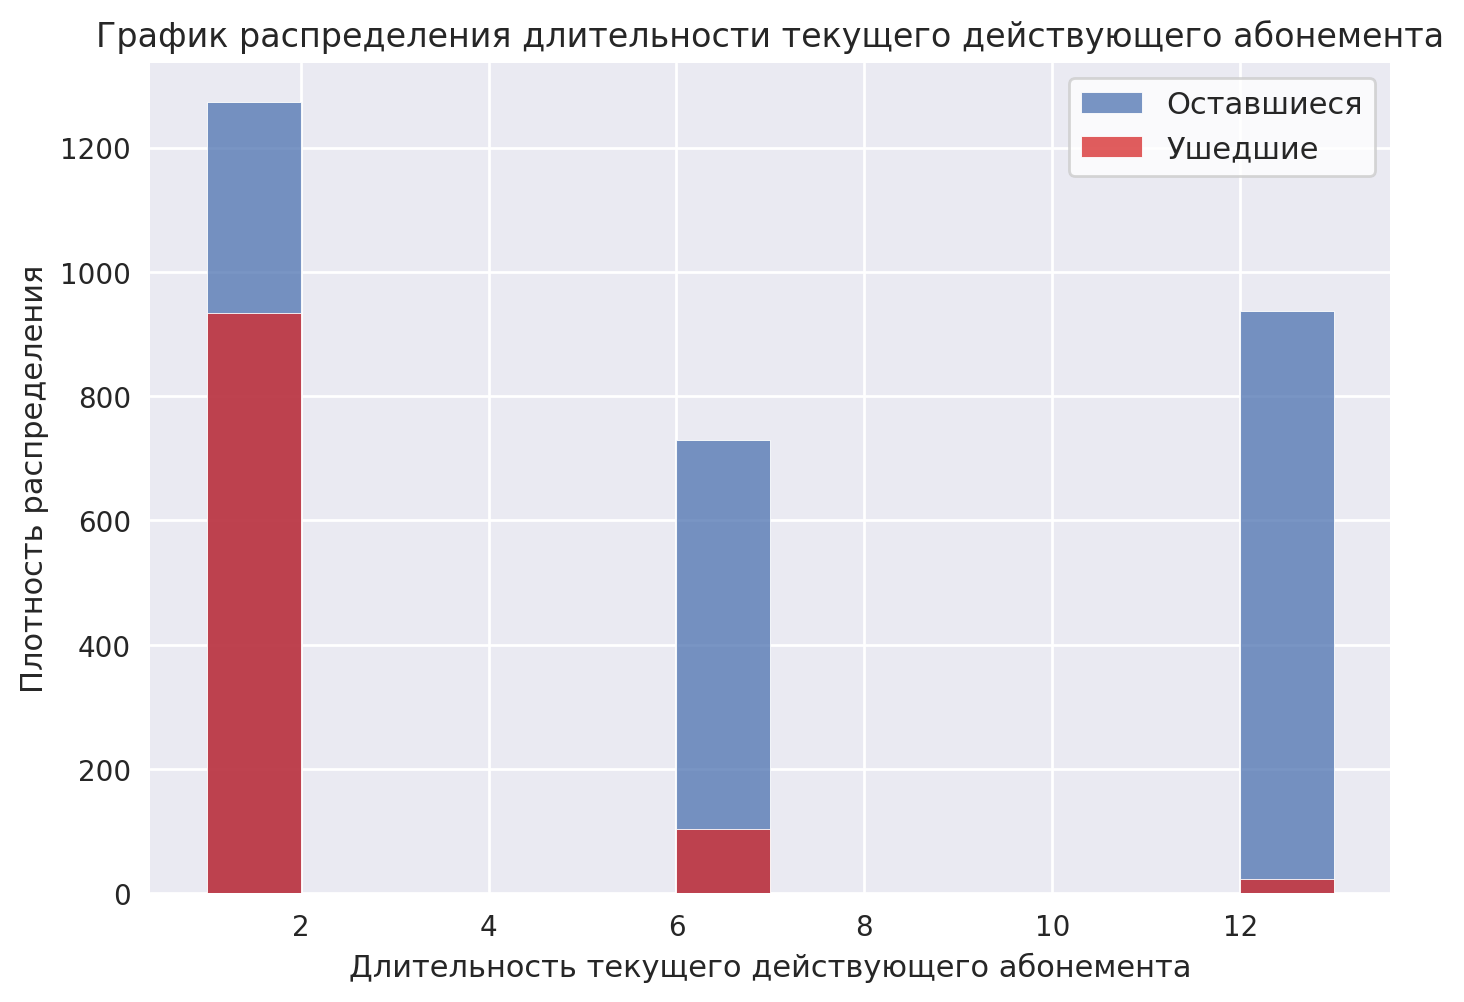

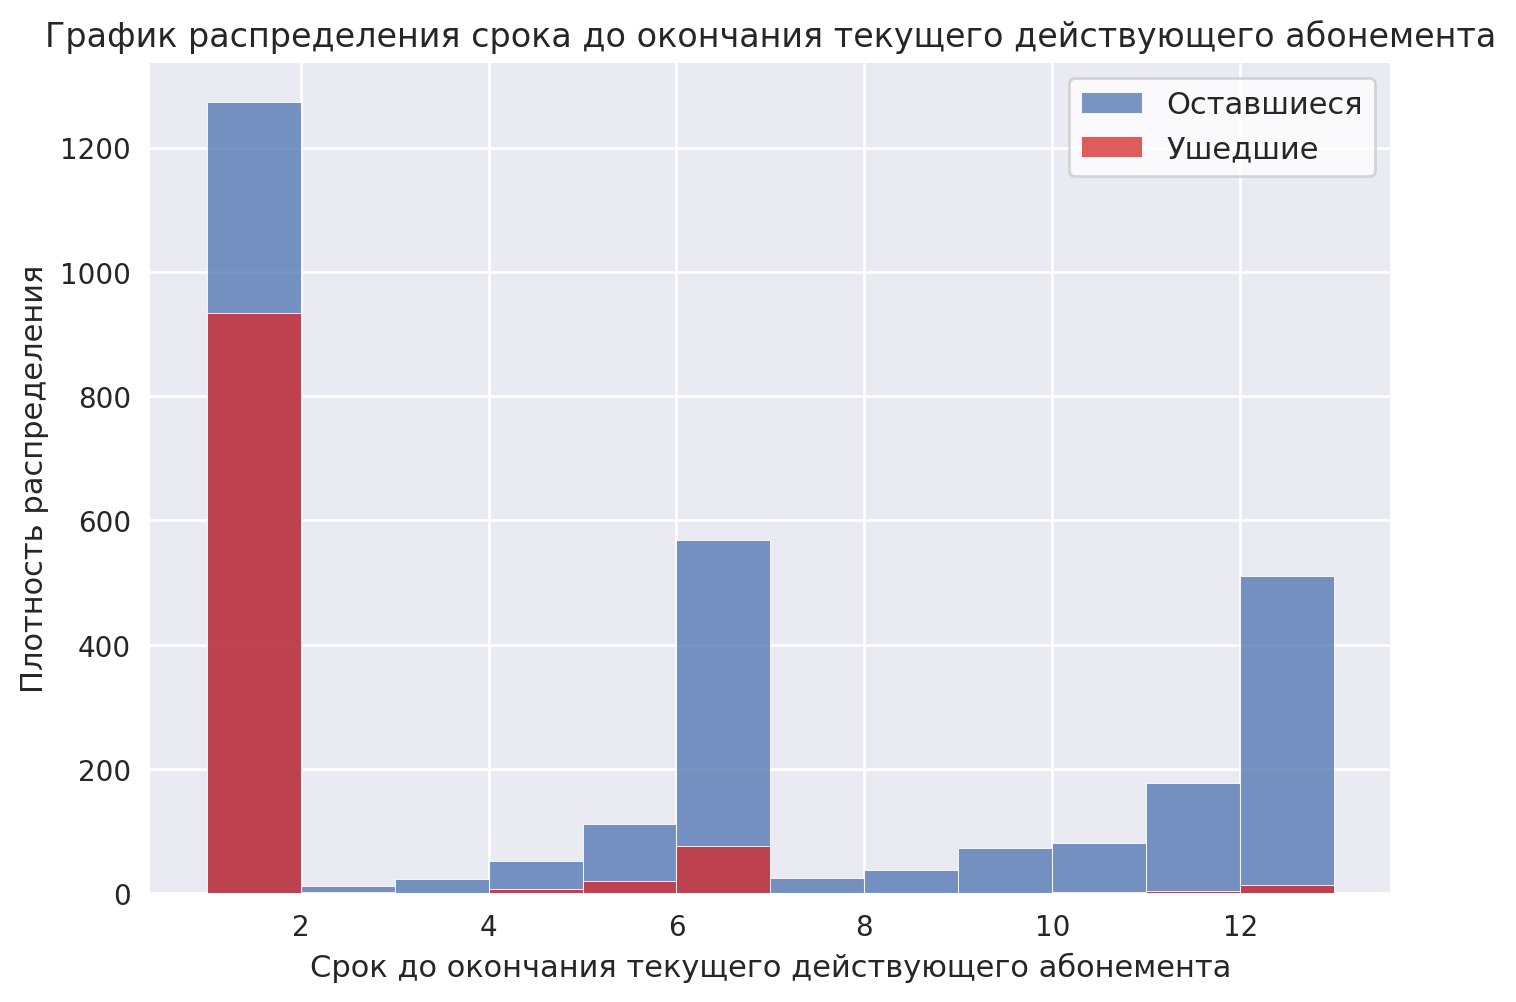

In [10]:
# создадим список с небинарными признаками с небольшим разбросом значений
num_features = ['age','lifetime','contract_period','month_to_end_contract']
titles= ['График распределения возраста',
         'График распределения времени с момента первого обращения в фитнес-центр',
         'График распределения длительности текущего действующего абонемента', 
         'График распределения срока до окончания текущего действующего абонемента']
labels= ['Возраст', 'Время с момента первого обращения в фитнес-центр',
         'Длительность текущего действующего абонемента',
         'Срок до окончания текущего действующего абонемента']

# построим графики распределения
for col, title, label in zip(num_features, titles, labels):
    with plt.style.context('seaborn'):
        sns.histplot(df[df['churn'] == 0][col], bins = range(int(min(df[col])), int(max(df[col]))+2))
        sns.histplot(df[df['churn'] == 1][col], bins = range(int(min(df[col])), int(max(df[col]))+2), color='tab:red')
    labels= ["Оставшиеся", "Ушедшие"]
    plt.grid(True)
    plt.title(title)
    plt.legend(labels)
    plt.xlabel(label)
    plt.ylabel('Плотность распределения')
    plt.show()

Выводы:

- Оставшиеся клиенты тратят немного больше ушедших на дополнительные услуги фитнес-центра.
- Оставшиеся клиенты ходят в зал чаще. На графике, отображаюшем посещаемость за последний месяц, видно всплеск у ушедших в нуле - эти клиенты вообще ни разу не сходили в зал.
- Средний возраст ушедших клиентов на 3-4 года меньше.
- Среди оставшихся клиентов время с момента первого обращения значительно выше.
- Оставшиеся клиенты основном покупают абонементы на 6 и 12 месяцев. А ушедшие - в большинстве покупали абонемент на 1 месяц.
- У ушедших в среднем гораздо меньше время до конца контракта, чем у оставшихся.

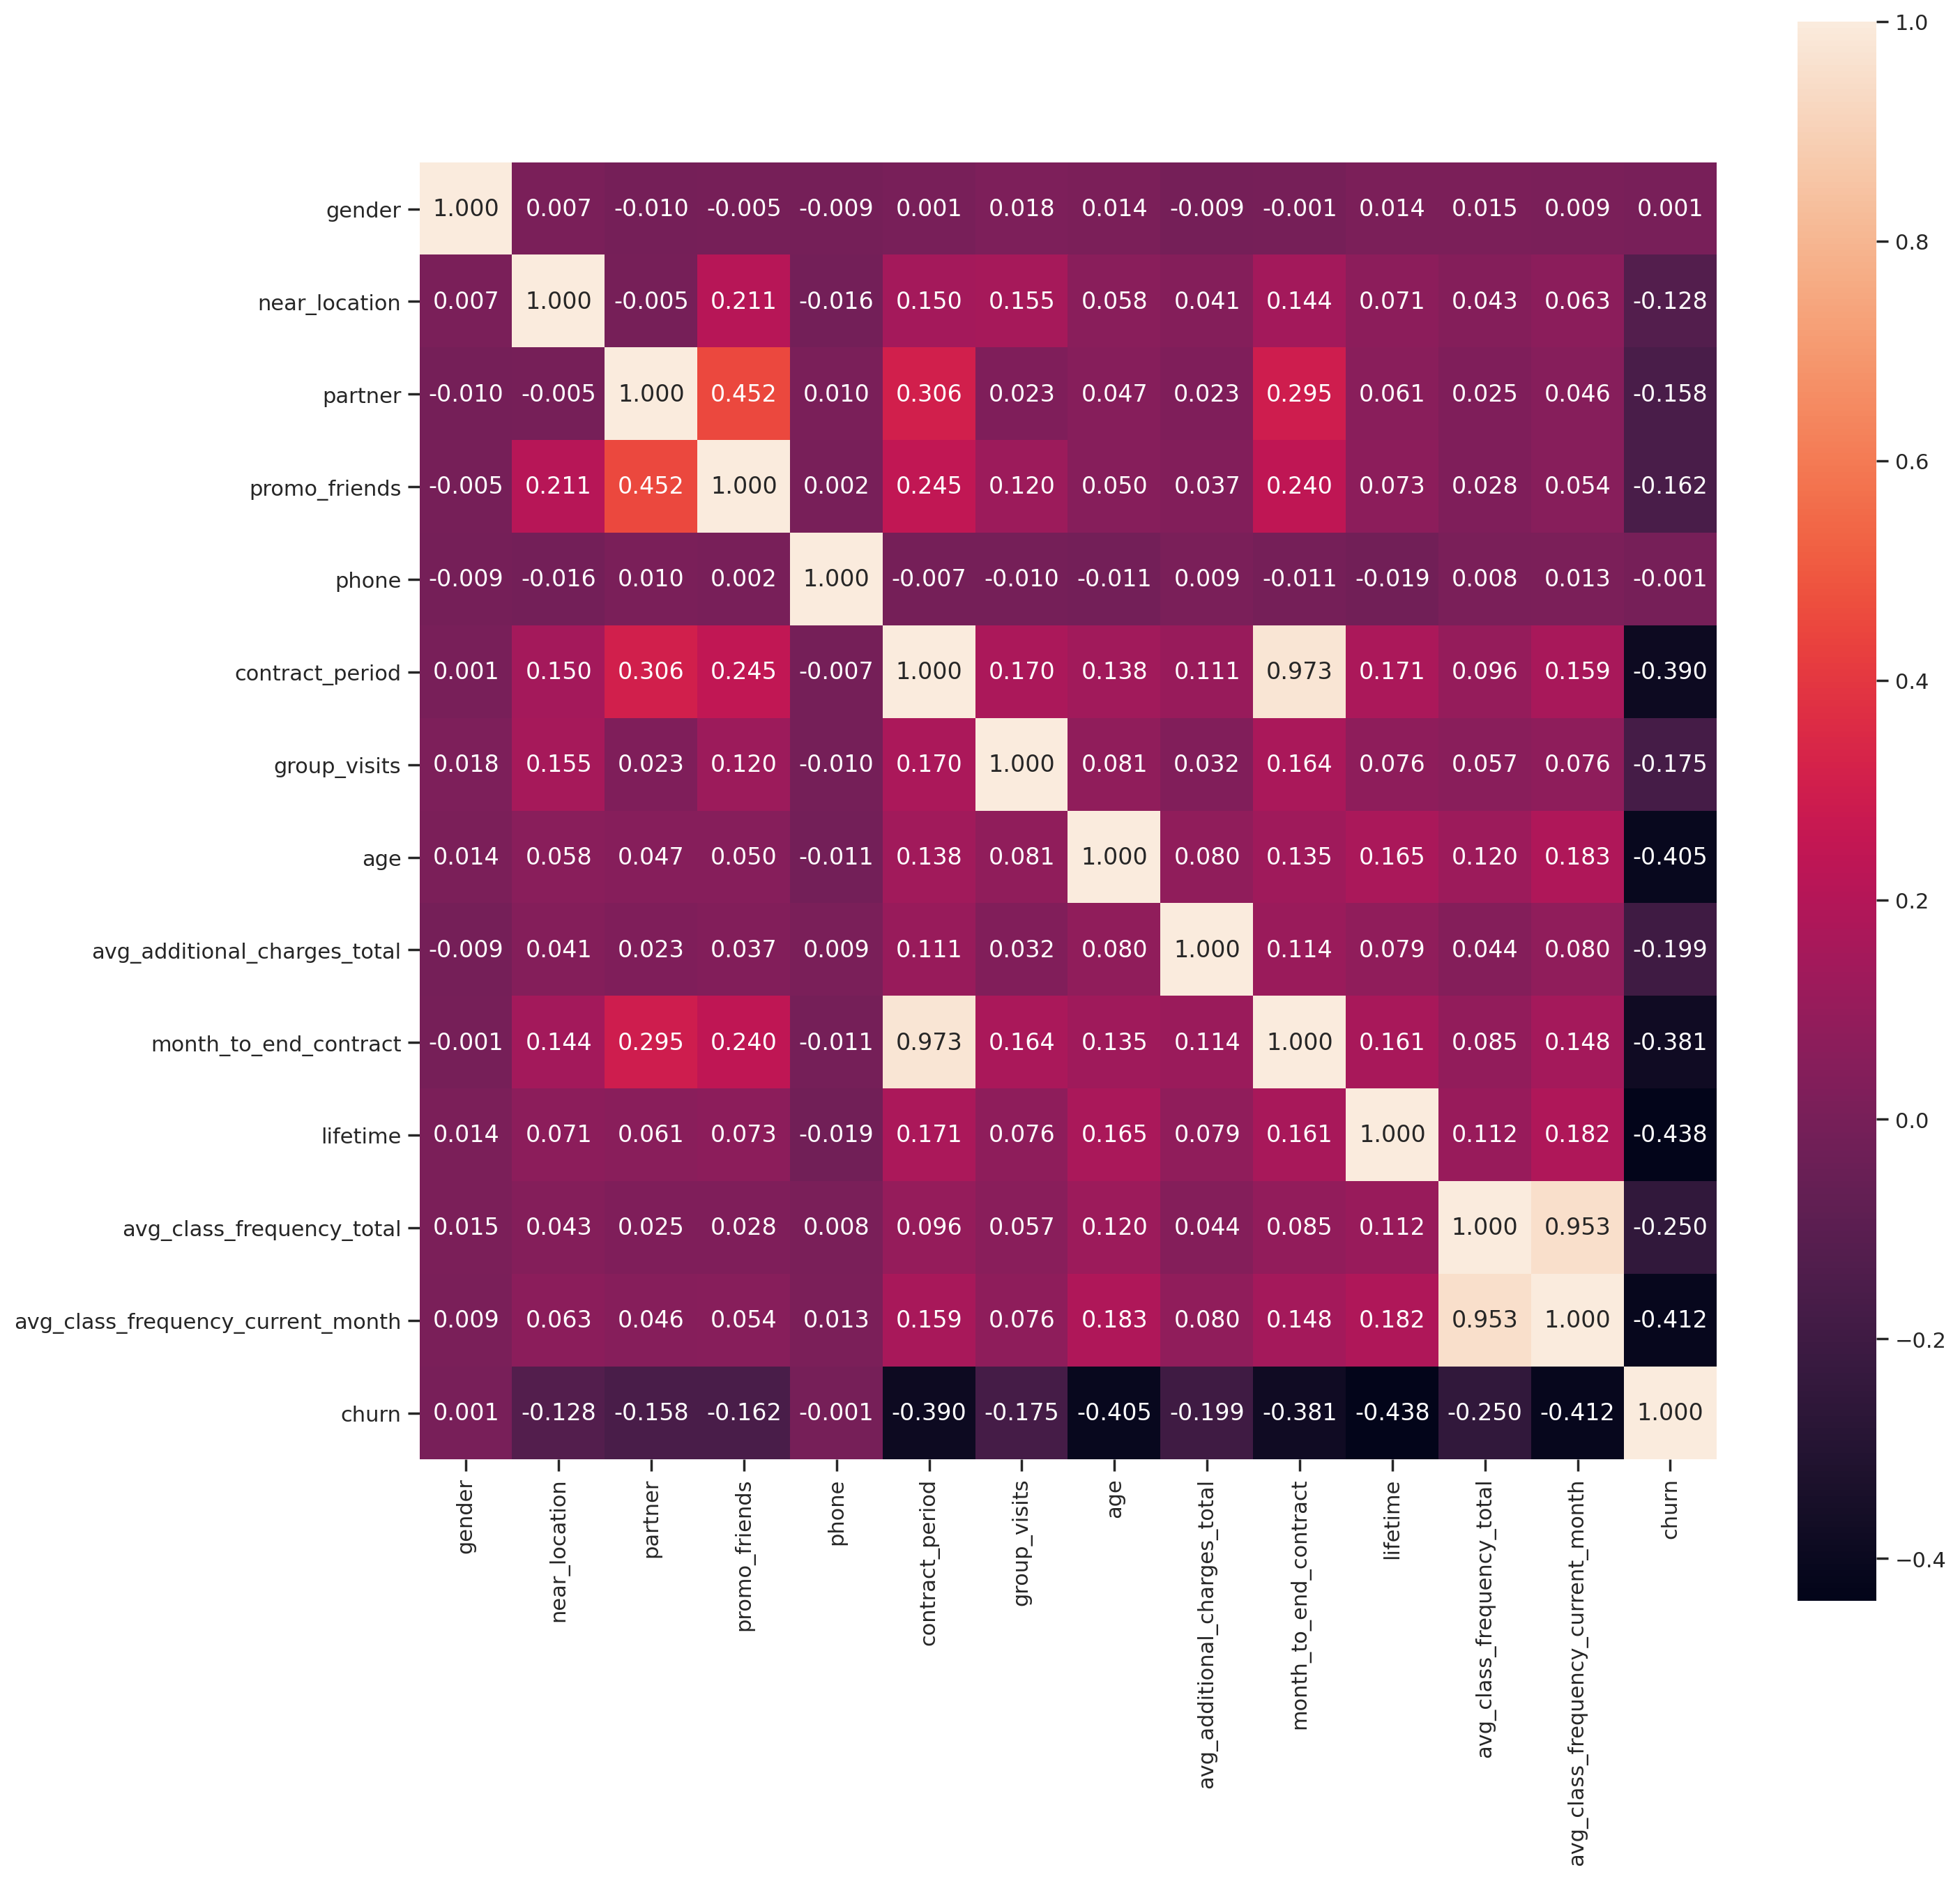

In [11]:
# создаем матрицу корреляции
corr_m = df.corr()

# вывод матрицы на экран в виде тепловой карты
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True, fmt=".3f")
plt.show()

Судя по матрице корреляций, нет признаков, с высокой вероятностью сообщающих, уйдет клиент или остнется. Зато есть две пары признаков с очень высокой корреляцией:

- contract_period и month_to_end_contract
- avg_class_frequency_total и avg_class_frequency_current_month

Во избежание мультиколлинеарности удалим по одному признаку из каждой пары.

In [12]:
df = df.drop('month_to_end_contract', axis = 1)
df = df.drop('avg_class_frequency_current_month', axis = 1)

**Выводы:**

1. В обеих группах одинаковы:
- доли мужчин и женщин
- доли клиентов с контактным телефоном и без
2. В группе оставшихся значительно больше (в разы):
- доля пришедщих по акции "Приведи друга" (в 2 раза)
- cредняя длительность абонемента и число месяцев до окончания абонемента (в 3 раза)
- доля ходящих на групповые занятия (в 2 раза)
- время с момента первого обращения (в 5 раз)
- средняя частота посещений в неделю за предыдущий месяц (в 2 раза)
3. В группе оставшихся больше (до 50%):
- доля живущих рядом (на 10%)
- доля пришедших из компании-партнера (на 50%)
- средний возраст клиентов (на 3 года)
- средняя выручка от других услуг центра (на 30%)
- средняя частота посещений в неделю за все время с начала действия абонемента (на 30%)

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Для этого:
1. Разобьем данные на обучающую и валидационную выборку
2. Обучим модель на train-выборке тремя способами:
- логистической регрессией;
- случайным лесом;
- градиентным бустингом.
3. Оценим для обеих моделей на валидационной выборке следующие метрики:
- Accuracy (доля правильных ответов) - это доля верно угаданных ответов из всех прогнозов.
- Precision (точность) - доля правильных ответов только среди целевого класса.
- Recall (полнота) - показывает, сколько реальных объектов целевого класса удалось обнаружить с помощью модели.
- F1 - сводная метрика, учитывающая баланс между метриками precision и recall.
- AUC-ROC - площадь под кривой ошибок — вероятность того, что наблюдение принадлежит к определенному классу.

In [13]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']
# создадим обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
def print_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    '''Функция для вывода метрик'''
    print(title)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [15]:
# обучаем модель логистической регрессии
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]
print_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
Accuracy: 0.87
Precision: 0.75
Recall: 0.74
F1: 0.75
ROC_AUC: 0.93


In [16]:
# обучаем модель случайного леса:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
print_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
Accuracy: 0.89
Precision: 0.76
Recall: 0.81
F1: 0.79
ROC_AUC: 0.94


In [17]:
# обучаем модель градиентного бустинга:
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 0)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_probabilities = gb_model.predict_proba(X_test)[:,1]
print_metrics(y_test, gb_predictions, gb_probabilities, title = 'Метрики для модели градиентного бустинга:')

Метрики для модели градиентного бустинга:
Accuracy: 0.88
Precision: 0.76
Recall: 0.81
F1: 0.78
ROC_AUC: 0.94


Все модели показали себя примерно одинаково хорошо. Посмотрим, какие признаки наши модели сочли наиболее важными.

In [18]:
# оценим важность признаков модели логистической регрессии
pd.DataFrame({'feature' : X_train.columns, 'coef' : lr_model.coef_[0]}).sort_values(by='coef', ascending=False)

,feature,coef
4,phone,1.132855
1,near_location,0.560562
0,gender,0.182071
2,partner,0.169432
8,avg_additional_charges_total,-0.003577
7,age,-0.041877
5,contract_period,-0.195373
10,avg_class_frequency_total,-0.336529
3,promo_friends,-0.575492
9,lifetime,-0.741793


Как ни странно, модель придала большую важность наличию контактного телефона - при его наличии вероятность оттока повышается. Согласно модели, реже уходят следующие клиенты:
- давние клиенты;
- пришедшие по акции по акции "Пригласи друга"
- те, кто чаще посещают зал
- те, у кого дом/работа рядом с финтес-центром
- те, у кого длительность текущего действующего абонемента выше
- клиенты постарше
- те, кто посещают групповые занятия


In [19]:
# оценим важность признаков модели случайного леса
pd.DataFrame({'feature' : X_train.columns, 'importance' : rf_model.feature_importances_}).\
            sort_values(by='importance', ascending=False)

,feature,importance
9,lifetime,0.340343
10,avg_class_frequency_total,0.164103
7,age,0.156007
8,avg_additional_charges_total,0.131775
5,contract_period,0.111678
6,group_visits,0.024546
2,partner,0.016897
0,gender,0.016637
3,promo_friends,0.015344
1,near_location,0.013604


Согласно нашей модели случайного леса, наиболее важными признаками являются:
1. Время с момента первого посещения
2. Среднее количество занятий в неделю
3. Возраст
4. Траты на дополнительные услуги
5. Длительность текущего абонемента

In [20]:
# оценим важность признаков модели градиентного бустинга
pd.DataFrame({'feature' : X_train.columns, 'importance' : gb_model.feature_importances_}).\
            sort_values(by='importance', ascending=False)

,feature,importance
9,lifetime,0.539635
5,contract_period,0.167175
7,age,0.145120
10,avg_class_frequency_total,0.090518
8,avg_additional_charges_total,0.039209
6,group_visits,0.010550
3,promo_friends,0.003186
1,near_location,0.002087
4,phone,0.001332
2,partner,0.000639


Наиболее важные признаки у модели градиентного бустинга совпадают с таковыми у случайного леса, однако их порядок поменялся:
1. Время с момента первого посещения
2. Длительность текущего абонемента
3. Возраст
4. Среднее количество занятий в неделю
5. Траты на дополнительные услуги

**Выводы:**
- Были построены модели логистической регрессии, случайного леса и градиентного бустинга.
- По результатам метрик все три модели показали себя примерно одинаково хорошо.
- Были проанализированы самые важные метрики в каждой модели.

## Кластеризация клиентов

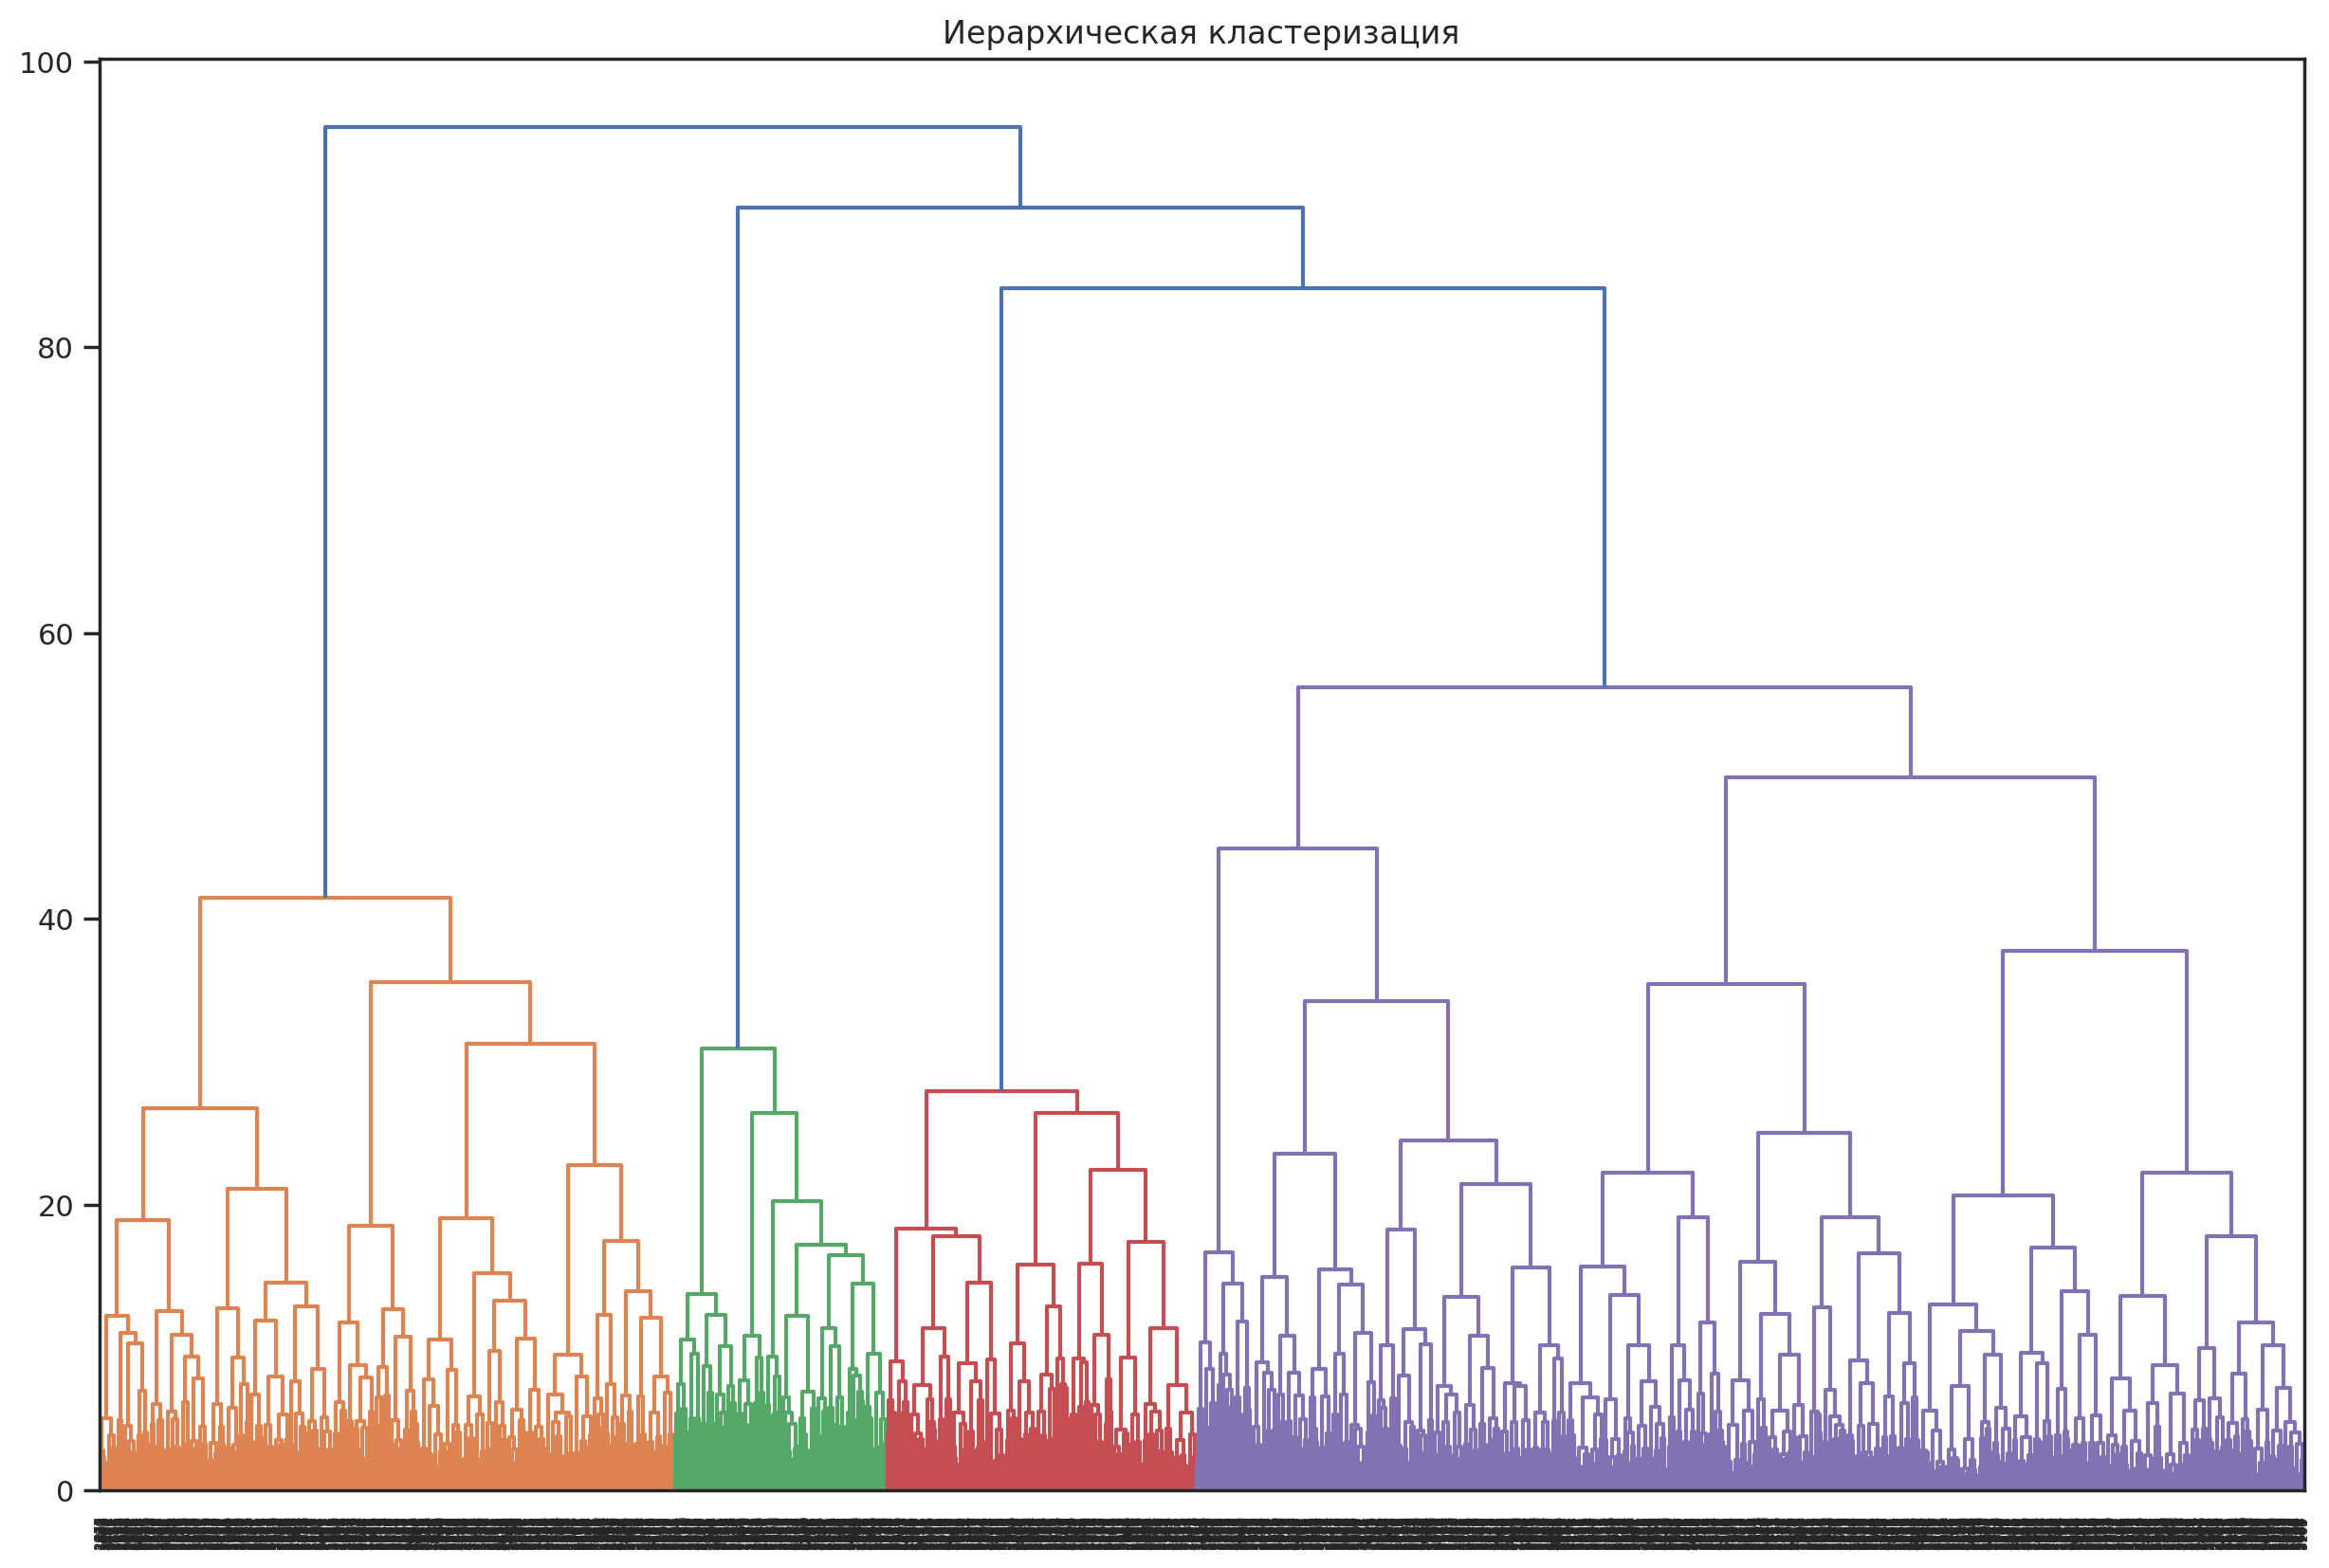

In [21]:
# создадим объект класса StandardScaler и применим его к датафрейму, отбросим столбец с оттоком
sc = StandardScaler()
x_sc = sc.fit_transform(X)

linked = linkage(x_sc, method = 'ward')

# построение дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Поделим наши данные на 5 кластеров.

In [22]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

# выводим статистику по средним значениям признаков по кластеру
df.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Визуализируем наши данные, чтобы нагляднее увидеть различия в кластерах.

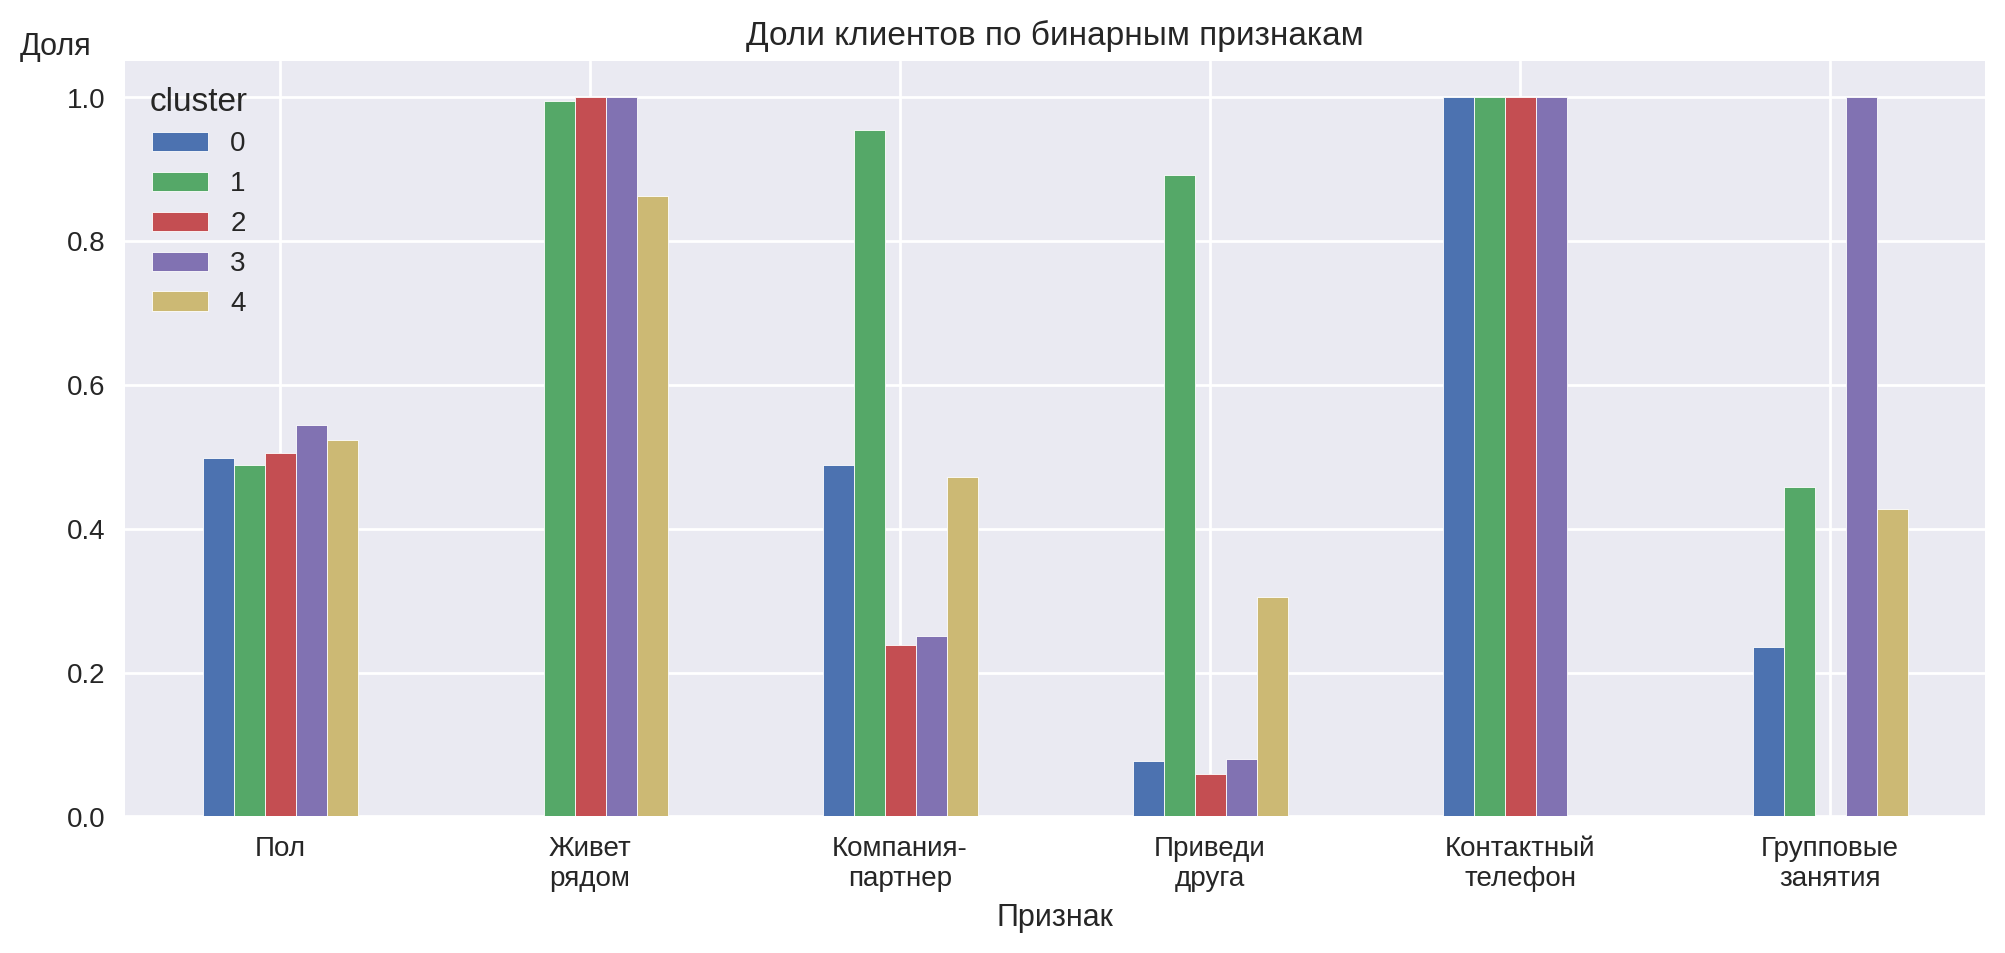

In [23]:
with plt.style.context('seaborn'):
    # сгруппируем по бинарным признакам и построим график
    df.groupby('cluster')[binary_features].agg('mean').\
    rename(columns={'gender': 'Пол','near_location':'Живет\nрядом','partner':'Компания-\nпартнер',\
                     'promo_friends':'Приведи\nдруга','phone':'Контактный\nтелефон','group_visits':'Групповые\nзанятия'}).\
    T.plot(kind='bar', stacked=False, figsize=(12, 5))
    plt.title('Доли клиентов по бинарным признакам')
    plt.xlabel('Признак')
    plt.ylabel('Доля', rotation=0, position = (0,1))
    plt.xticks(rotation=0)
    plt.show()

Видно, что:
- во всех кластерах примерно одинаковое соотношение мужчин и женщин;
- в <font color='blue'>кластере 0</font> никто не живет/не работает рядом с фитнес-центром;
- большая часть людей из <font color='green'>кластера 1</font> являются сотрудниками компании-партнера и/или пришли по акции "Пригласи друга";
- клиенты из <font color='orange'>кластера 4</font> не оставляли контактного телефона, а из всех остальных - оставляли;
- клиенты из <font color='red'>кластера 2</font> не посещают групповые занятия;
- все клиенты из <font color='purple'>кластера 3</font> посещают групповые занятия.

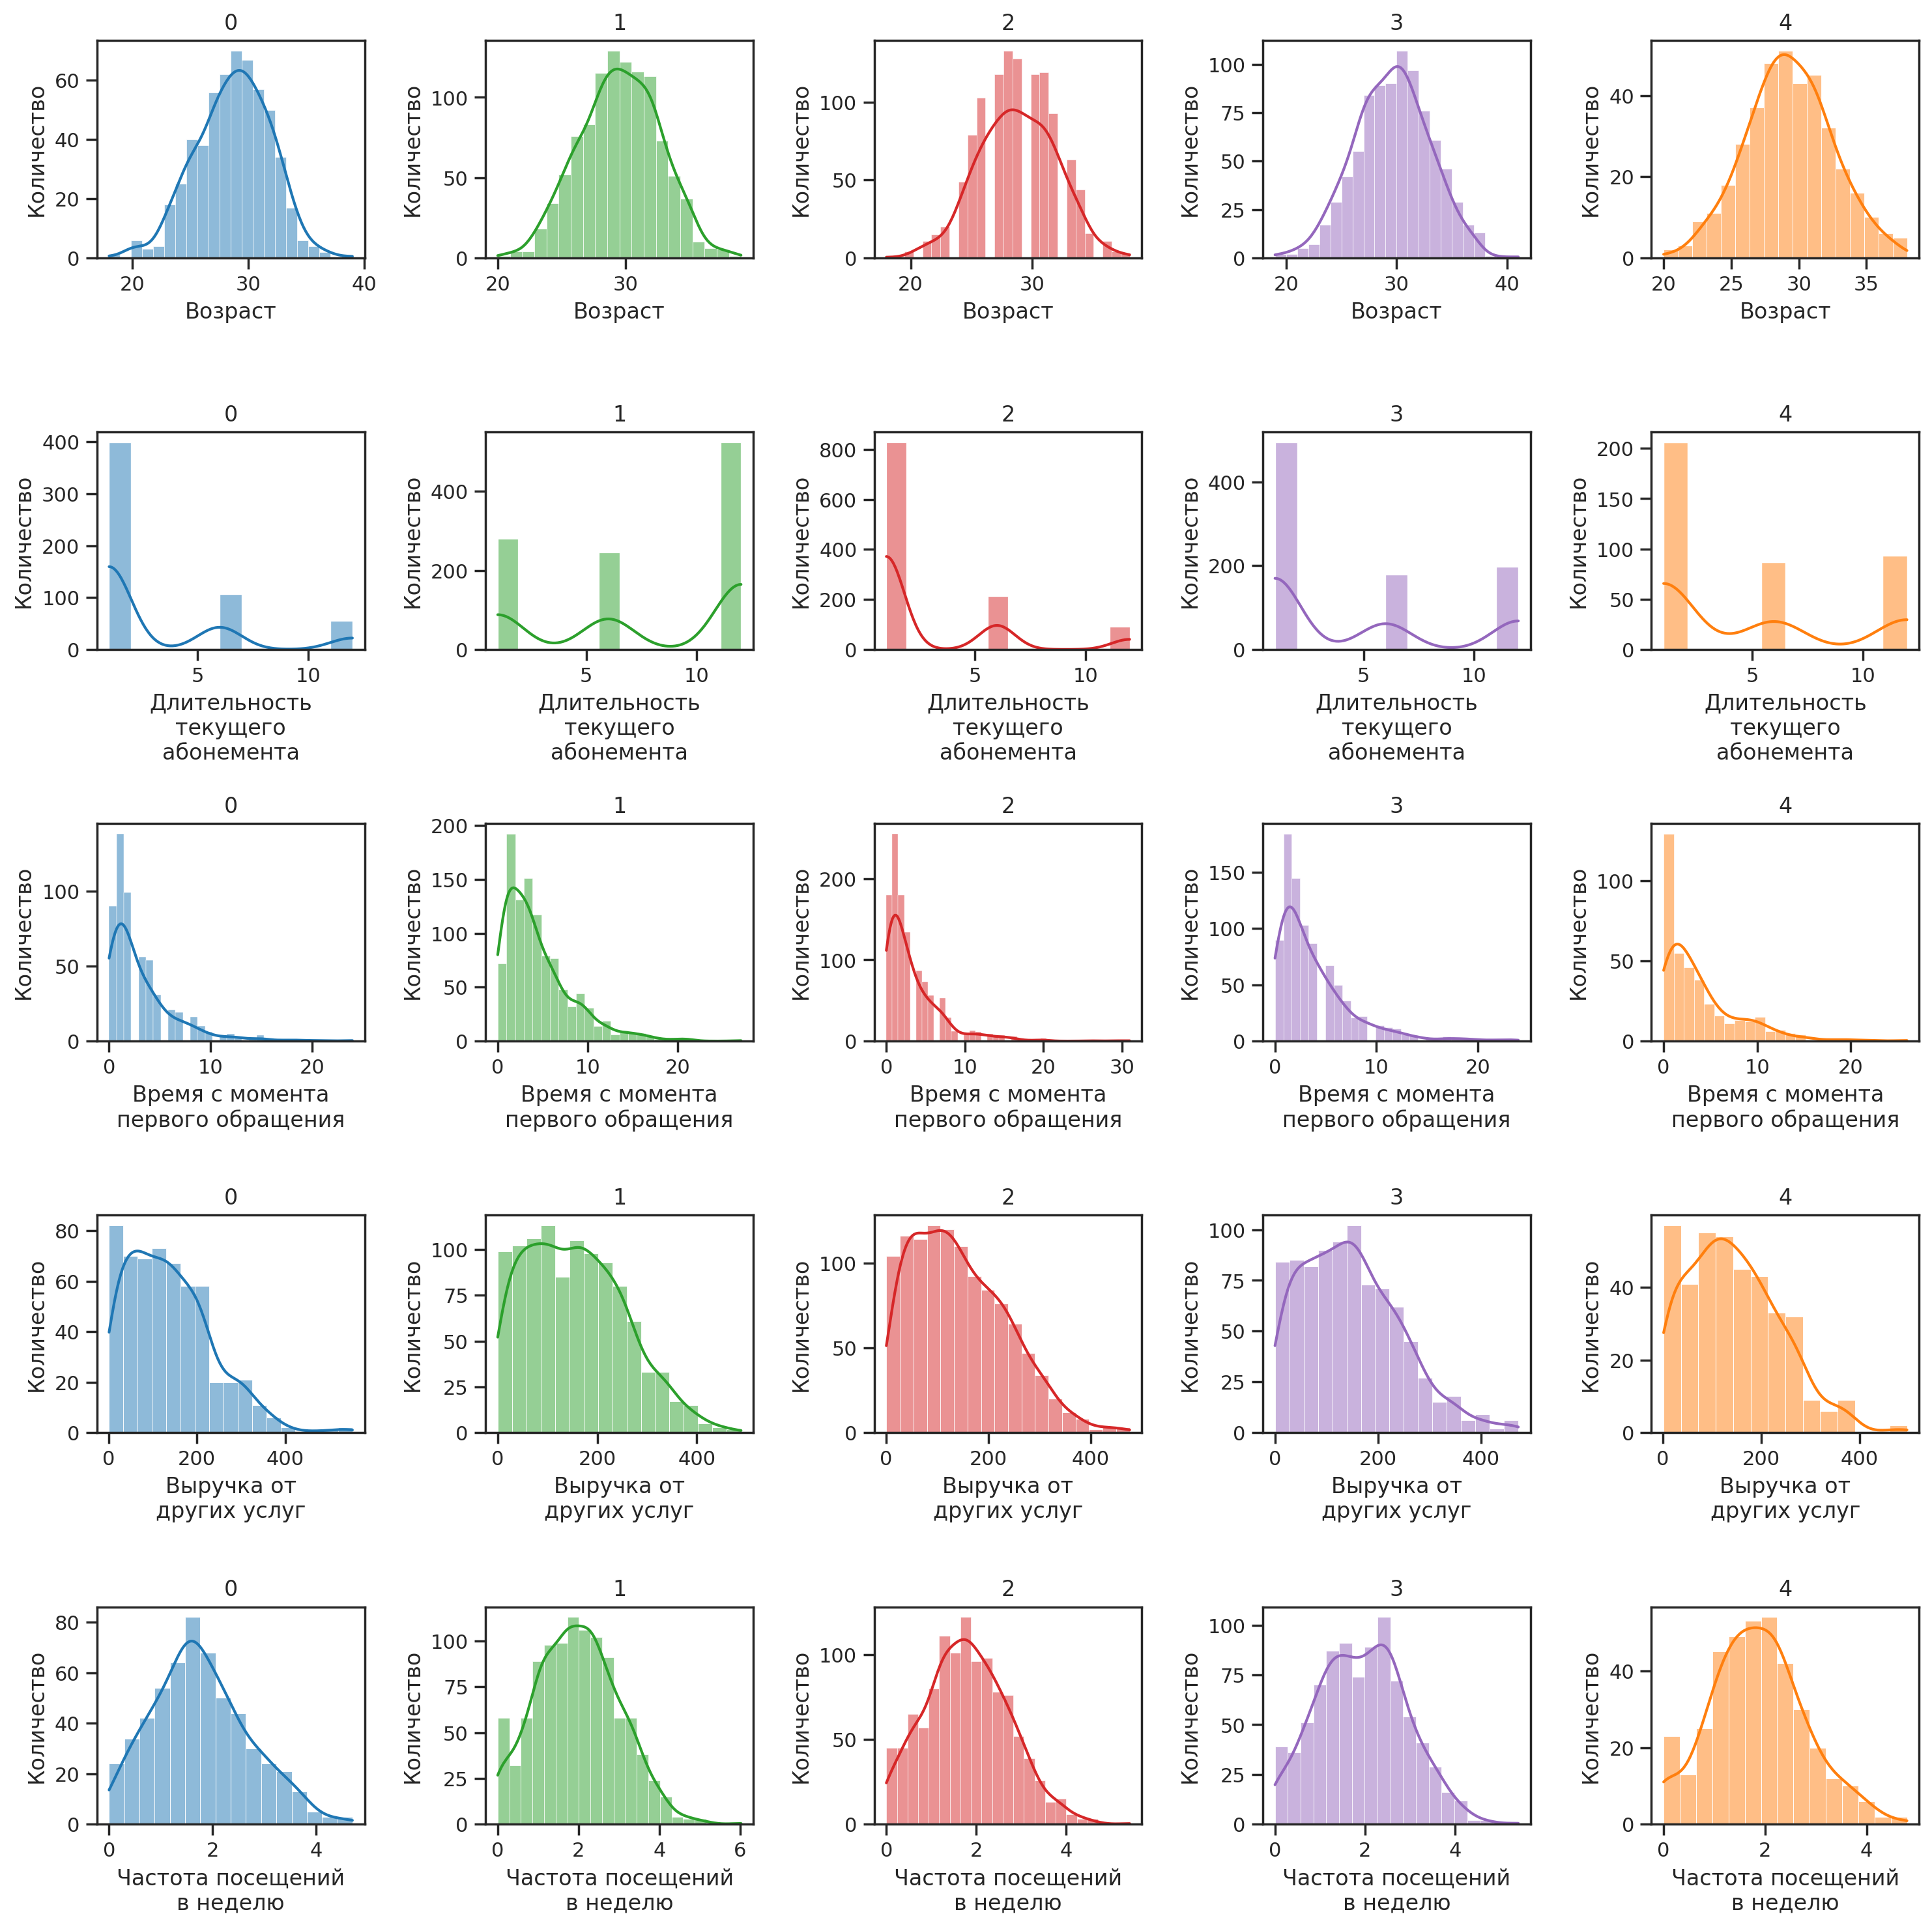

In [24]:
# список признаков
num_features = ['age','contract_period','lifetime','avg_additional_charges_total','avg_class_frequency_total']
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:orange']
titles = ['Возраст', 'Длительность\nтекущего\nабонемента', 'Время с момента\nпервого обращения',
          'Выручка от\nдругих услуг', 'Частота посещений\nв неделю']
# построим гистограммы
fig, axes = plt.subplots(5, 5)
i=0
for feature in num_features:
    for k in range(5):
        sns.histplot(df[df['cluster']==k][feature], ax=axes[i][k], kde=True, color=colors[k]).set(xlabel=titles[i], ylabel='Количество')
        axes[i][k].set_title(k)
    i+=1
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
plt.show()

Из этих графиков видно, что:
- средний возраст в кластерах практически не отличается;
- наиболее длительные абонементы - у клиентов из <font color='green'>кластера 1</font>, около половины клиентов имеют 12-месячный абонемент; во всех остальных кластерах большинство клиентов имеет абонемент на один месяц;
- больше всего новых клиентов - в <font color='orange'>кластере 4</font>;
- выручка от других услуг практически не отличается от кластера к кластеру;
- частота посещений клиентов во всех кластерах примерно одинакова.

Посмотрим долю оттока по кластерам.

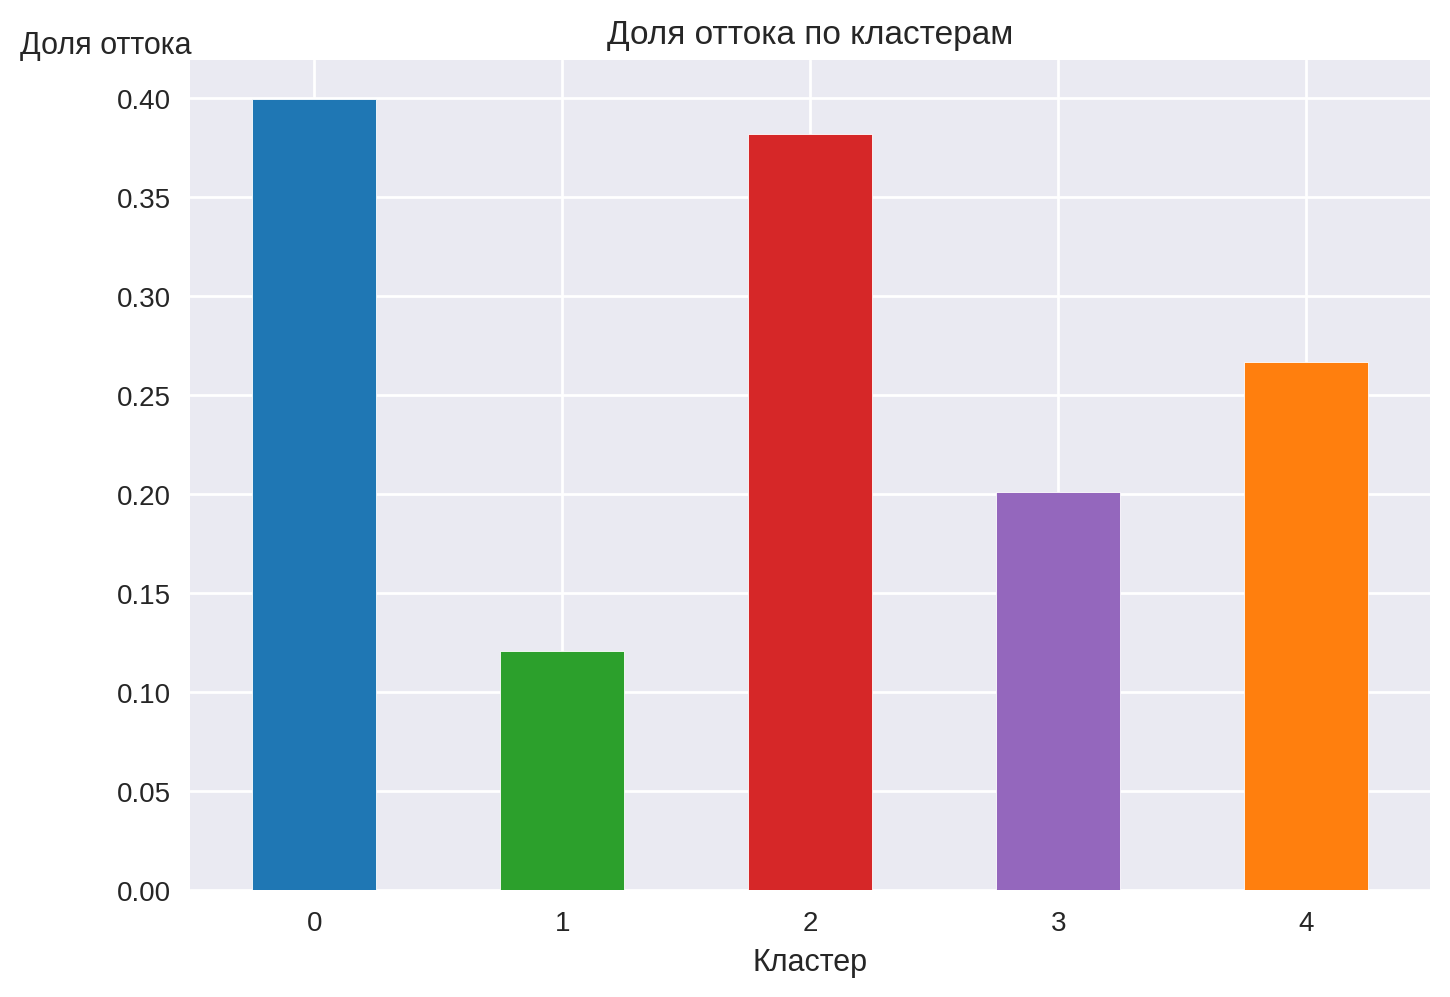

In [25]:
with plt.style.context('seaborn'):
    # построим график оттока по кластерам
    df.groupby('cluster')['churn'].agg('mean').plot(kind='bar', color=colors)
    plt.title('Доля оттока по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel('Доля оттока', rotation=0, position = (0,1))
    plt.xticks(rotation=0)
    plt.show()

Наименьшая доля оттока - у кластера 1, 12%. А вот у кластера 0 и кластера 2 доля оттока - около 40%.

**Выводы:**
- пол, средний возраст, наличие контактного телефона практически не влияет на отток;
- клиенты, живущие и работающие в других районах, попали в кластер с наибольшим оттоком;
- клиенты, не посещающие групповые занятия, попали в кластер со вторым по размеру оттоком;
- наименьший отток у кластера, в который попали клиенты, которые являются сотрудниками компании-партнера и/или пришли по акции "Пригласи друга", а также имеют самые длительные абонементы.

## Выводы и рекомендации

Согласно проведенному исследованию, имеют место быть следующие рекомендации:
- Расширить сеть и открыть фитнес-центры во всех районах. Клиенты, которые не живут/ не работают рядом с фитнес-центром, чаще остальных перестают его посещать. Потому целесообразно открыть фитнес-центры во всех районах города.
- Завлекать клиентов на групповые занятия. Можно проводить маркетинговые кампании в этом направлении и/или делать первое групповое занятие бесплатным.
- Стараться продавать клиенту абонементы на более длительный срок - например, с помощью скидок на длительные абонементы.
- Популяризировать акцию "Пригласи друга" - заниматься веселее и пригласившему, и приглашенному, да и уходить, оставив товарища одного, совесть не позволит :) Можно совместить этот пункт с предыдущим и давать скидки тому, кто приводит друзей.
- Расширить сотрудничество с компаниями, которые смогут покупать абонементы своим сотрудникам со скидками.
- Мотивировать регулярно ходить на занятия, что привьет привычку. Почему бы не устроить акцию "занимайся трижды в неделю в течение месяца и получи скидку 50% на годовой абонемент"? ;)